# Beers in the USA: a prediction of State of origin based on beer tastes

## imports

In [6]:
from src.data.save_tar_gz import tar_gz_to_csv
from src.data.load_data import load_data_from_csv
from src.utils.data_utils import *
from src.data.additional_data import *
import warnings
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import src.data.wrangling as wrangling
from datetime import datetime

# NEEED TO ADD A FUNCTION CALL TO LOAD AND CLEAN DATA

## Loading the data into dict. of dataframes

This part loads the data from the specified path. There are two options. The first one is to load directly from the compressed .tar.gz files, which is needed for the first run and that will save the data files in readable .csv files. Once we have these .csv files, we can directly load from them using the second option.


### Option 1: data still in .tar.gz

In [7]:
# Use these lines for the first loading, tar.gz files must be in the data/ folder. After executing them, directly do the wrangling to save clean .csv

# warnings.filterwarnings("ignore")
# data = tar_gz_to_csv(load_path= 'data/', save_path='data/raw/', load_text = False)
# warnings.filterwarnings("default")

### Option 2: data in .csv

In [8]:
# Use this line if you have all the data extracted to wrangled csv files under data/raw in subfolders BeerAdvocate, RateBeer, and MatchedBeerData.
# It loads the data into 3 dictionnaries containing the dataframes

# data_ba, data_rb, data_matched = load_data_from_csv('data/raw/')

# print(data_ba.keys())
# print(data_rb.keys())
# print(data_matched.keys())

# #remove textual review columns if needed
# remove_txt_columns(data_ba, data_rb, data_matched)

# data_ba['BeerAdvocate_ratings.csv'].head()

### Option 3: load from clean_path

In [9]:
Ratebeer_path = lambda path: f"{path}/Ratebeer"
BeerAdvocate_path = lambda path: f"{path}/BeerAdvocate"
Matched_path = lambda path: f"{path}/MatchedBeerData"
path = "data/clean"

Ratebeer_file = lambda file: f"{Ratebeer_path(path)}/{file}"
BeerAdvocate_file = lambda file: f"{BeerAdvocate_path(path)}/{file}"
Matched_file = lambda file: f"{Matched_path(path)}/{file}"

# Tests à la con

In [10]:
def get_ba_beer_merged():
    ba_usa_ratings = pd.read_csv("data/clean/BeerAdvocate/usa_ratings.csv")
    ba_usa_users = pd.read_csv("data/clean/BeerAdvocate/usa_users.csv")

    ba_usa_ratings = ba_usa_ratings.merge(ba_usa_users[['user_id', 'location']], on='user_id', how='left')
    ba_usa_ratings['state'] = ba_usa_ratings['location'].apply(lambda x: x.split(', ')[-1])

    return ba_usa_ratings


ba_usa_ratings = get_ba_beer_merged()

In [11]:
#users_matched = data_matched['matched_beer_data_users.csv']
#users_ba = data_ba['BeerAdvocate_users.csv']
#users_rb = data_rb['RateBeer_users.csv']

# need to add column of beer rating
#ba_beers = pd.read_csv(f"{BeerAdvocate_path(clean_path)}/beers.csv")

# grouped by beer and state
column_to_group = 'style'

#ba_usa_ratings['state'] = ba_usa_ratings['location'].apply(lambda x: x.split(', ')[-1])
reviews_by_beer_state = ba_usa_ratings.groupby(['state', column_to_group]).mean(numeric_only=True).reset_index()
#reviews_by_state = ba_usa_ratings['abv', 'location'].groupby('location').mean()#.reset_index(name='review_count')
reviews_by_beer_state = reviews_by_beer_state.loc[:, ['state', column_to_group, 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']]
# to know how many got grouped
reviews_by_beer_state['review_count'] = ba_usa_ratings.groupby(['state', column_to_group]).size().values
reviews_by_beer_state = reviews_by_beer_state.loc[reviews_by_beer_state["review_count"] > 10]    # only more than 10 reviews by beer

# selected_rows = reviews_by_beer_state[reviews_by_beer_state['style'] == "English Pale Ale"]

beer_styles = pd.unique(reviews_by_beer_state[column_to_group])
print(len(beer_styles))
# selected_rows



104


## Top-Rated Beer Styles

In [12]:
#top-rated beer styles overall
top_beer_styles = reviews_by_beer_state.groupby('style')['overall'].mean().sort_values(ascending=False)
print("Top-rated beer styles across the U.S.:")
print(top_beer_styles.head(10))

#top-rated beer style per state
top_beer_styles_by_state = reviews_by_beer_state.loc[reviews_by_beer_state.groupby('state')['overall'].idxmax()]
print("Top-rated beer styles by state:")
print(top_beer_styles_by_state[['state', 'style', 'overall']])




Top-rated beer styles across the U.S.:
style
Gose                                2.974140
Kvass                               2.867680
Eisbock                             2.702948
Berliner Weissbier                  2.642580
American Wild Ale                   2.590513
English Pale Mild Ale               2.578963
American Double / Imperial Stout    2.568663
Baltic Porter                       2.564610
Weizenbock                          2.561228
Roggenbier                          2.546682
Name: overall, dtype: float64
Top-rated beer styles by state:
               state                      style   overall
8            Alabama    American Dark Wheat Ale  2.819444
148           Alaska      English Dark Mild Ale  4.154762
239          Arizona                    Braggot  3.444444
352         Arkansas                    Eisbock  3.521739
475       California                       Gose  2.750821
558         Colorado                    Eisbock  3.062925
683      Connecticut                 

## Diversity in Preferences

Beer styles with the highest variance in ratings across states:
style
Happoshu                 0.422093
Braggot                  0.289281
Roggenbier               0.282390
English Dark Mild Ale    0.266829
Gueuze                   0.265421
Kristalweizen            0.257993
Bière de Garde           0.241892
Kvass                    0.221174
Eisbock                  0.208452
English Strong Ale       0.203835
Name: overall, dtype: float64


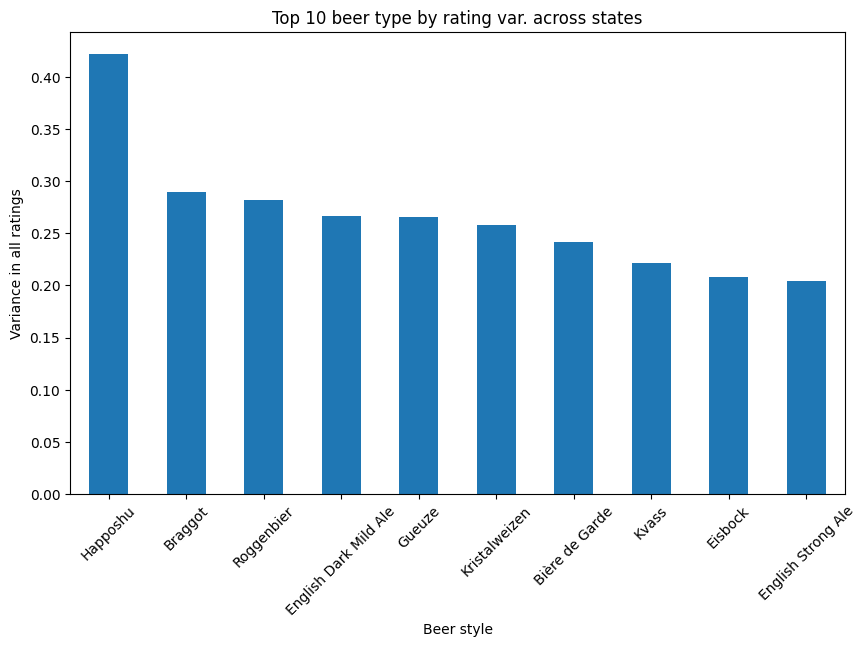

In [13]:
#variance in ratings for each beer style across all states
rating_variance_by_style = reviews_by_beer_state.groupby('style')['overall'].var().sort_values(ascending=False)
print("Beer styles with the highest variance in ratings across states:")
print(rating_variance_by_style.head(10))

# plot top10 by highest var.
plt.figure(figsize=(10, 6))
rating_variance_by_style.head(10).plot(kind='bar')
plt.title('Top 10 beer type by rating var. across states')
plt.xlabel('Beer style')
plt.ylabel('Variance in all ratings')
plt.xticks(rotation=45)
plt.show()


## Correlation of data for global rating

Correlation of criterion with rating by beer style
                                 appearance     aroma    palate     taste  \
Altbier                           -0.078269 -0.063418 -0.045403 -0.032804   
American Adjunct Lager             0.288332  0.317479  0.322582  0.344913   
American Amber / Red Ale           0.062904  0.106254  0.097755  0.104936   
American Amber / Red Lager         0.150192  0.155615  0.151391  0.151476   
American Barleywine               -0.044680 -0.032289 -0.039025 -0.026704   
...                                     ...       ...       ...       ...   
Braggot                            0.113204  0.133813  0.122774  0.158288   
Faro                               0.097795  0.186831  0.156079  0.196818   
Lambic - Unblended                 0.186612  0.153148  0.157018  0.182692   
Bière de Champagne / Bière Brut    0.332704  0.378910  0.391410  0.403145   
Roggenbier                         0.056153  0.077936  0.027464  0.069238   

                        

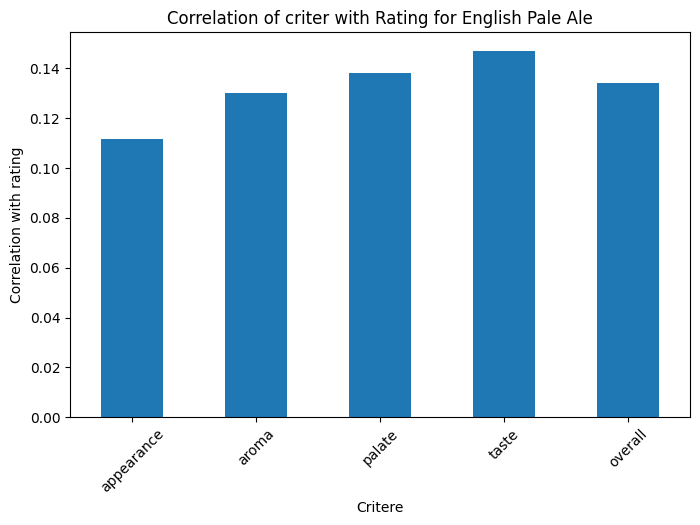

In [14]:
#criterias to analyse corr. with rating
criteria = ['appearance', 'aroma', 'palate', 'taste', 'overall']
criteria_correlation_by_style = {}

for style in beer_styles:
    style_data = reviews_by_beer_state[reviews_by_beer_state['style'] == style]
    if len(style_data) > 20:
        correlations = style_data[criteria + ['rating']].corr()['rating'].drop('rating')
        criteria_correlation_by_style[style] = correlations

criteria_correlation_df = pd.DataFrame(criteria_correlation_by_style)
criteria_correlation_df = criteria_correlation_df.T

print("Correlation of criterion with rating by beer style")
print(criteria_correlation_df)

specific_style = "English Pale Ale"
if specific_style in criteria_correlation_df.index:
    criteria_correlation_df.loc[specific_style].plot(kind='bar', figsize=(8, 5))
    plt.title(f'Correlation of criter with Rating for {specific_style}')
    plt.xlabel('Critere')
    plt.ylabel('Correlation with rating')
    plt.xticks(rotation=45)
    plt.show()



# locality of consumption

In [15]:
def get_ba_beer_merged():
    ba_usa_ratings = pd.read_csv("data/clean/BeerAdvocate/usa_ratings.csv")
    ba_usa_users = pd.read_csv("data/clean/BeerAdvocate/usa_users.csv")

    ba_usa_ratings = ba_usa_ratings.merge(ba_usa_users[['user_id', 'location']], on='user_id', how='left')
    ba_usa_ratings['state'] = ba_usa_ratings['location'].apply(lambda x: x.split(', ')[-1])
    ba_usa_ratings['date'] = ba_usa_ratings['date'].apply(lambda timestamp: datetime.fromtimestamp(timestamp).date())
    # datetime.fromtimestamp(timestamp) 
    return ba_usa_ratings


ba_usa_ratings = get_ba_beer_merged()

In [16]:
user_state_dic = {}

for state in pd.unique(ba_usa_ratings['state']):
    user_state_dic[state] = ba_usa_ratings[ba_usa_ratings['state'] == state]

In [17]:
user_state_dic['California'].head()

,Unnamed: 0,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,...,rating,user_name_nan,abv_nan,appearance_nan,aroma_nan,palate_nan,taste_nan,overall_nan,location,state
8,11,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,2013-04-25,GraduatedCashew,graduatedcashew.730089,...,3.00,0,0,1,1,1,1,1,"United States, California",California
131,146,St. Patrick's Best,20842,Strangford Lough Brewing Company Ltd,10093,English Bitter,4.2,2010-03-09,Mosstrooper,mosstrooper.235403,...,3.65,0,0,0,0,0,0,0,"United States, California",California
145,187,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,2003-08-04,beerguy101,beerguy101.137,...,2.68,0,0,0,0,0,0,0,"United States, California",California
153,198,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,2002-09-24,zerk,zerk.422,...,3.11,0,0,0,0,0,0,0,"United States, California",California
162,209,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,2001-04-03,Todd,todd.2,...,3.95,0,0,0,0,0,0,0,"United States, California",California


In [18]:
def load_breweries():
    breweries = pd.read_csv("data/clean/BeerAdvocate/breweries.csv")
    breweries['location'] = breweries['location'].apply(lambda x: x.replace('United States, ', ''))
    breweries['state'] = breweries['location'].apply(lambda x: x.split(', ')[-1])
    breweries.loc[breweries['location'].str.contains('Canada, '), 'location'] = 'Canada'
    breweries.loc[breweries['location'].str.contains('United Kingdom, '), 'location'] = 'United Kingdom'
    breweries = breweries.rename(columns={'id': 'brewery_id'})
    
    return breweries



breweries = load_breweries()

breweries.head()

,Unnamed: 0,brewery_id,location,name,nbr_beers,state
0,0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5,Kyrgyzstan
1,1,39913,Kyrgyzstan,Arpa (АРПА),1,Kyrgyzstan
2,2,39914,Kyrgyzstan,Bear Beer,4,Kyrgyzstan
3,3,39915,Kyrgyzstan,Blonder Pub,4,Kyrgyzstan
4,4,39916,Kyrgyzstan,Kellers Bier,2,Kyrgyzstan


In [19]:
def load_user_state_dic(ba_usa_ratings_df, breweries_df):
    user_state_dic = {}

    for state in pd.unique(ba_usa_ratings_df['state']):
        user_state_dic[state] = ba_usa_ratings_df[ba_usa_ratings_df['state'] == state]

    for key in user_state_dic.keys():
        user_state_dic[key] = user_state_dic[key].merge(breweries_df[['brewery_id', 'state']], on='brewery_id', how='left')
        user_state_dic[key] = user_state_dic[key].rename(columns={'state_x': 'user_state', 'state_y': 'brewery_state'})
        user_state_dic[key] =  user_state_dic[key][~ user_state_dic[key]["brewery_state"].str.contains("<a href")]

    return user_state_dic

user_state_dic = load_user_state_dic(ba_usa_ratings, breweries)

In [183]:
def get_provenance_by_state(user_state_dic):
    dic_state_provenance  = {key: {} for key in user_state_dic.keys()}
    for key in user_state_dic.keys():
        dic_state_provenance[key]['local_count'] = user_state_dic[key][user_state_dic[key]['user_state'] == user_state_dic[key]['brewery_state']].shape[0]
        dic_state_provenance[key]['national_count'] = user_state_dic[key][user_state_dic[key]['brewery_state'].isin(user_state_dic.keys() - [key])].shape[0]
        dic_state_provenance[key]['foreign_count'] = user_state_dic[key][~user_state_dic[key]['brewery_state'].isin(user_state_dic.keys())].shape[0]
    return dic_state_provenance

dic_state_provenance = get_provenance_by_state(user_state_dic)

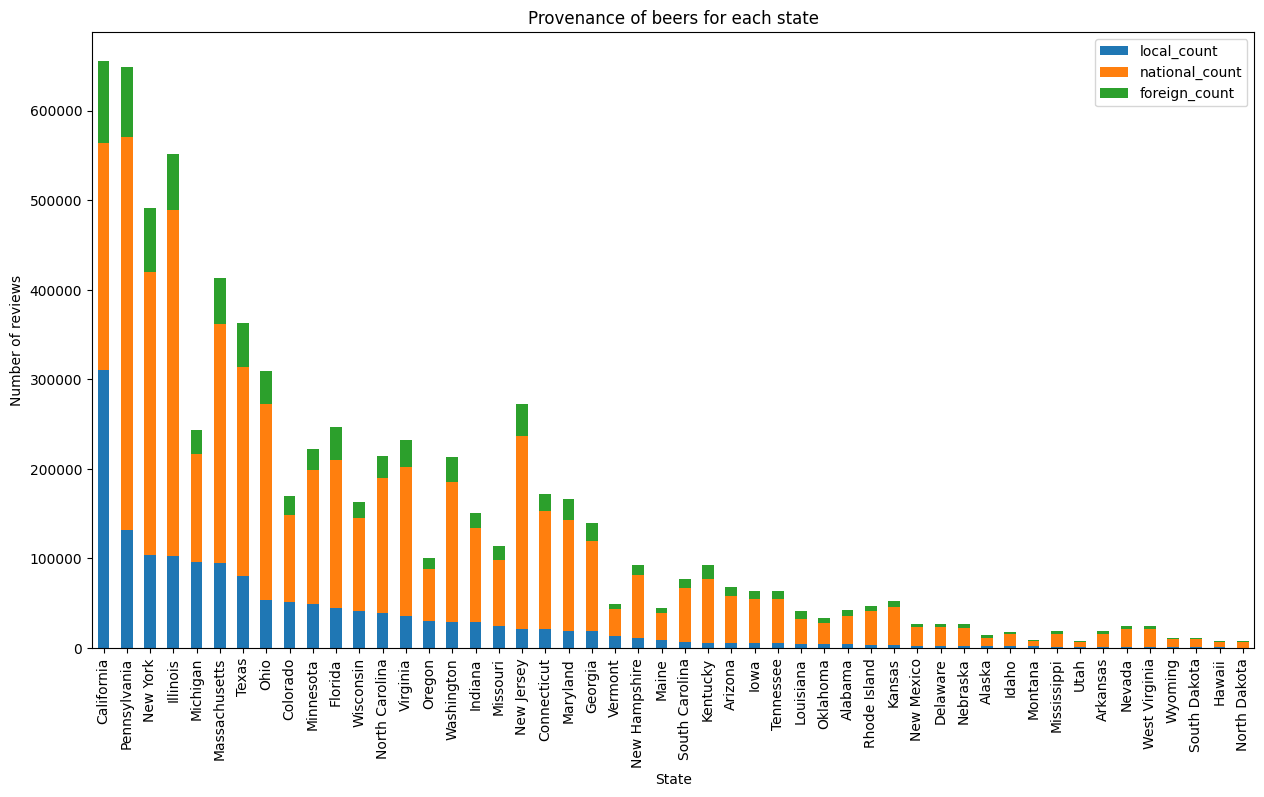

In [21]:
state_provenance_df = pd.DataFrame(dic_state_provenance).T
state_provenance_df = state_provenance_df.sort_values(by='local_count', ascending=False)
state_provenance_df.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Provenance of beers for each state')
plt.xlabel('State')
plt.ylabel('Number of reviews')
plt.show()


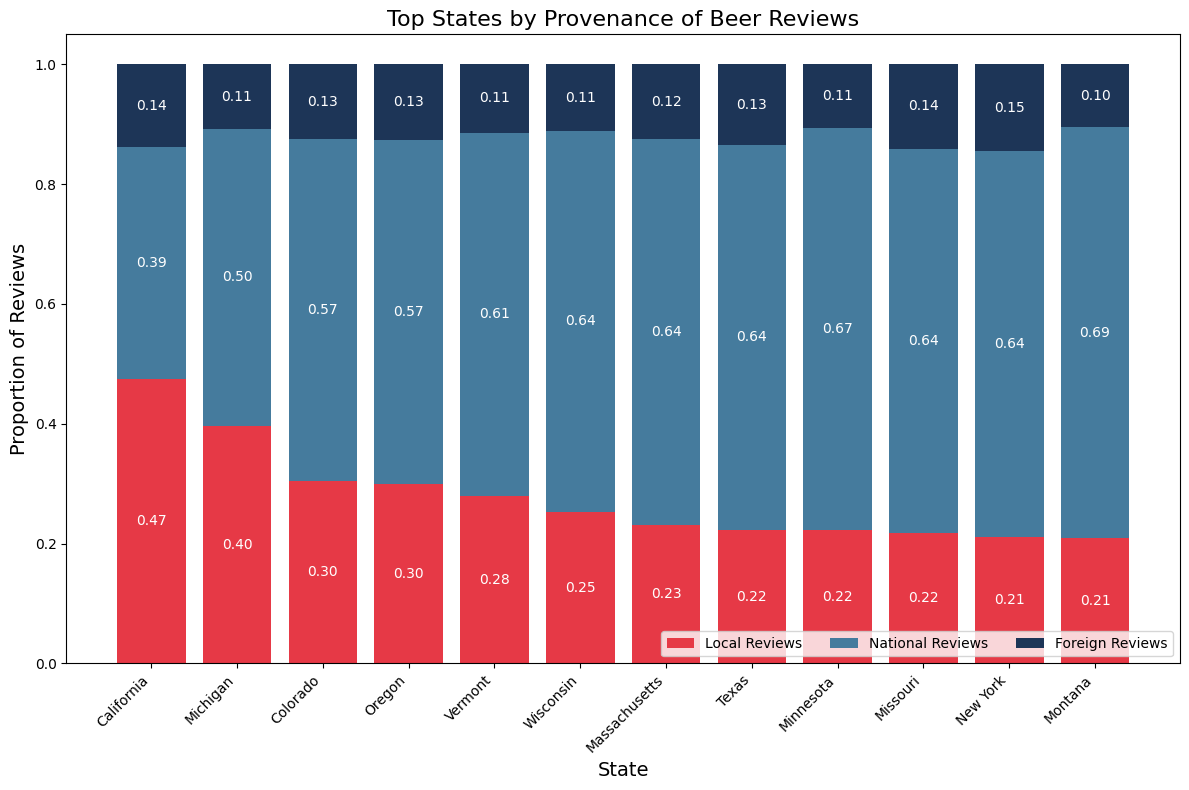

In [184]:
import numpy as np

sort_options = ["local_count", "national_count", "foreign_count", "local_nation_count"]

def top_states_by_provenance(dic_state_provenance, ratio=True):
    
    state_provenance_df = pd.DataFrame(dic_state_provenance).T
    state_provenance_df["total_count"] = state_provenance_df["local_count"] + state_provenance_df["national_count"] + state_provenance_df["foreign_count"]
    state_provenance_df["local_nation_count"] = state_provenance_df["local_count"] + state_provenance_df["national_count"]
    if ratio:
        state_provenance_df["local_count"] = state_provenance_df["local_count"] / state_provenance_df["total_count"]
        state_provenance_df["national_count"] = state_provenance_df["national_count"] / state_provenance_df["total_count"]
        state_provenance_df["local_nation_count"] = state_provenance_df["local_nation_count"] / state_provenance_df["total_count"]
        state_provenance_df["foreign_count"] = state_provenance_df["foreign_count"] / state_provenance_df["total_count"]
    return state_provenance_df

def plot_stacked_bar_provenance2(dic_state_provenance, top_k=10, sort_option="foreign_count", ascending=False, colors=None, width=0.8, ratio=True, figsize=(12, 8)):
    state_provenance_df = top_states_by_provenance(dic_state_provenance, ratio=ratio)
    state_provenance_df = state_provenance_df.sort_values(by=sort_option, ascending=ascending).head(top_k)
    import matplotlib.pyplot as plt
    
    if colors is None:
        colors = {
            "local_count": "#e63946",
            "national_count": "#457b9d",
            "foreign_count": "#1d3557"
        }
    
    categories = ['local_count', 'national_count', 'foreign_count']
    categories.remove(sort_option)
    categories.insert(0, sort_option)


    if len(colors) != len(categories):
        raise ValueError("The length of colors must match the number of categories.")

    fig, ax = plt.subplots(figsize=figsize)
    
    bottom = np.zeros(len(state_provenance_df))
    for idx, category in enumerate(categories):
        p = ax.bar(
            state_provenance_df.index,
            state_provenance_df[category],
            width=width,
            bottom=bottom,
            label=category.replace('_', ' ').replace('count', 'reviews').title(),
            color=colors[category],
        )
        barlabels = ax.bar_label(p, label_type='center', color='white', fmt='{:.2f}' if ratio else "{:.0f}")
        bottom += state_provenance_df[category].values
    ax.legend(ncols=len(categories),
            loc='lower right' if ratio and not ascending else 'upper right', fontsize='medium')
    return fig, ax

fig, ax = plot_stacked_bar_provenance2(dic_state_provenance, top_k=12, sort_option="local_count", ascending=False, width=0.8, ratio=True)
ax.set_title('Top States by Provenance of Beer Reviews', fontsize=16)
ax.set_xlabel('State', fontsize=14)
ax.set_ylabel('Proportion of Reviews', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:
ba_usa_ratings_merged = ba_usa_ratings.merge(breweries[['brewery_id', 'state']], on='brewery_id', how='left')
ba_usa_ratings_merged = ba_usa_ratings_merged.rename(columns={'state_x': 'user_state', 'state_y': 'brewery_state'})
ba_usa_ratings_merged = ba_usa_ratings_merged[~ba_usa_ratings_merged["brewery_state"].str.contains("<a href")]
states = ba_usa_ratings_merged[ba_usa_ratings_merged["location"].str.contains("United States,")]["location"].map(lambda x: x.replace("United States, ", "")).unique()

In [179]:
def transform_to_distribution(row):
    if row.sum() <= 0:
        return row
    return row/row.sum()

def get_state_adjacency_matrix(ratings_breweries_merged, states, as_ratio=True, drop_world=True):
    state_matrix = ratings_breweries_merged.groupby(by=["user_state", "brewery_state"]).size().unstack(fill_value=0)
    foreign_counts = state_matrix.drop(columns=states, errors='ignore').T.sum().fillna(0)
    state_matrix = state_matrix.reindex(index=sorted(list(states)), columns=sorted(list(states)), fill_value=0)
    state_matrix = state_matrix.loc[:, sorted(list(states))]
    if not drop_world:
        state_matrix["World"] = foreign_counts
    if as_ratio:
        state_matrix = state_matrix.apply(transform_to_distribution, axis=1)
    
    return state_matrix

def get_counts_for_state_matrix(matrix, as_ratio=False):
    if "World" not in matrix.columns:
        raise KeyError("World column not found cannot get foreign_count")
    local_count = np.diagonal(matrix.drop(columns=["World"]))
    foreign_count = matrix['World']
    non_world_sum = np.array(state_adj_matrix.drop(columns=['World']).T.sum())
    national_count = non_world_sum - local_count
    ret = pd.DataFrame({
        'local_count': local_count.tolist(),
        'national_count': national_count.tolist(),
        'foreign_count': foreign_count
    })
    if as_ratio:
        ret = ret.div(ret.sum(axis=1)).fillna(0)
    return ret
    
state_adj_matrix = get_state_adjacency_matrix(ba_usa_ratings_merged, states, as_ratio=True, drop_world=False)
counts = get_counts_for_state_matrix(state_adj_matrix)
counts


,local_count,national_count,foreign_count
user_state,,,
Alabama,0.096420,0.743642,0.159938
Alaska,0.168922,0.629967,0.201111
Arizona,0.086816,0.768625,0.144559
Arkansas,0.051579,0.808000,0.140421
California,0.474251,0.387033,0.138716
Colorado,0.303898,0.570935,0.125168
Connecticut,0.120406,0.769330,0.110263
Delaware,0.098160,0.799595,0.102244
Florida,0.180295,0.671255,0.148450


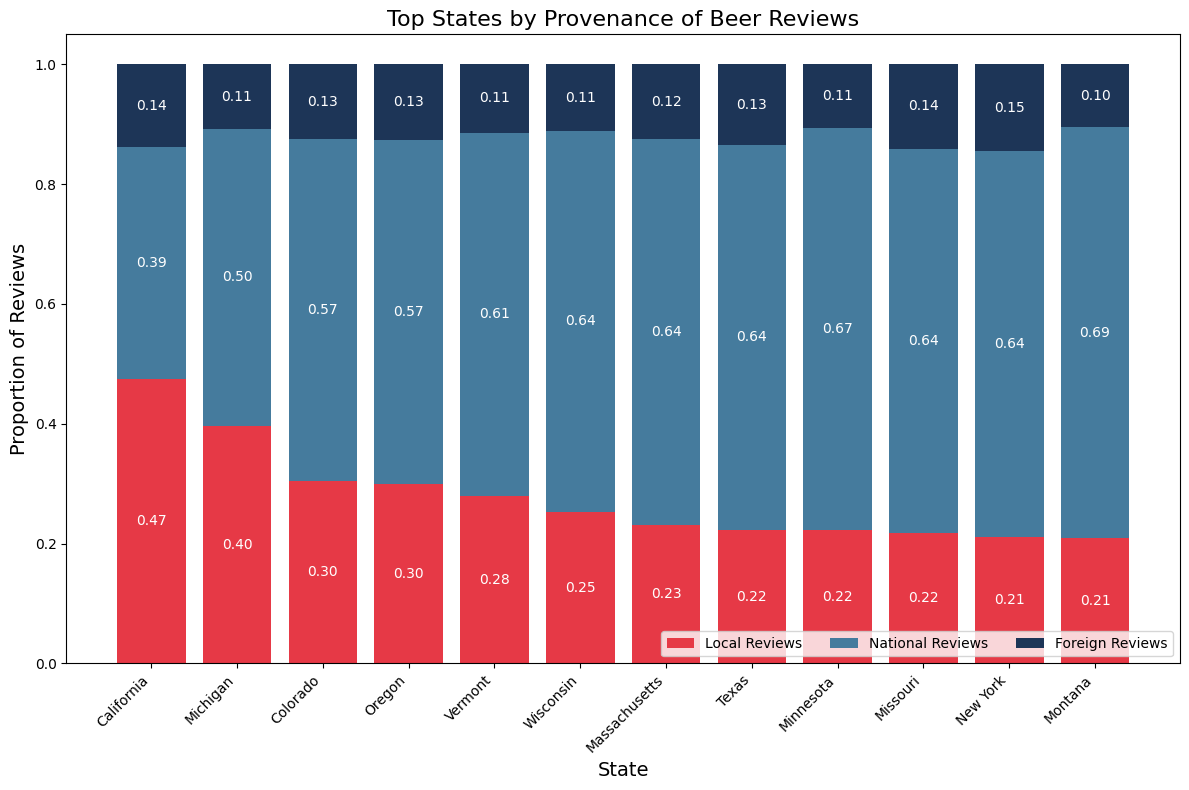

In [ ]:
def plot_provenance(ratings_breweries_merged, top_k=10, sort_option="local_count", ascending=False, width=0.8, as_ratio=True, figsize=(12, 8), colors=None):
    state_adj_matrix = get_state_adjacency_matrix(ratings_breweries_merged, states, as_ratio=as_ratio, drop_world=False)
    us_counts_df = get_counts_for_state_matrix(state_adj_matrix)
    us_counts_df = us_counts_df.sort_values(by=sort_option, ascending=ascending).head(top_k)
    
    # Put the metric we are sorting by underneath so it look prettier
    categories = list(us_counts_df.columns)
    categories.remove(sort_option)
    categories.insert(0, sort_option)

    fig, ax = plt.subplots(figsize=figsize)
    
    bottom = np.zeros(len(us_counts_df))
    for idx, category in enumerate(categories):
        p = ax.bar(
            us_counts_df.index,
            us_counts_df[category],
            width=width,
            bottom=bottom,
            label=category.replace('_', ' ').replace('count', 'reviews').title(),
            color=colors[category],
        )
        barlabels = ax.bar_label(p, label_type='center', color='white', fmt='{:.2f}' if as_ratio else "{:.0f}")
        bottom += us_counts_df[category].values
    ax.legend(ncols=len(categories),
            loc='lower right' if as_ratio and not ascending else 'upper right', fontsize='medium')
    return fig, ax

colors = {
    "local_count": "#e63946",
    "national_count": "#457b9d",
    "foreign_count": "#1d3557"
}

fig, ax = plot_provenance(ba_usa_ratings_merged, top_k=12, sort_option="local_count", ascending=False, width=0.8, as_ratio=True, colors=colors)
ax.set_title('Top States by Provenance of Beer Reviews', fontsize=16)
ax.set_xlabel('State', fontsize=14)
ax.set_ylabel('Proportion of Reviews', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

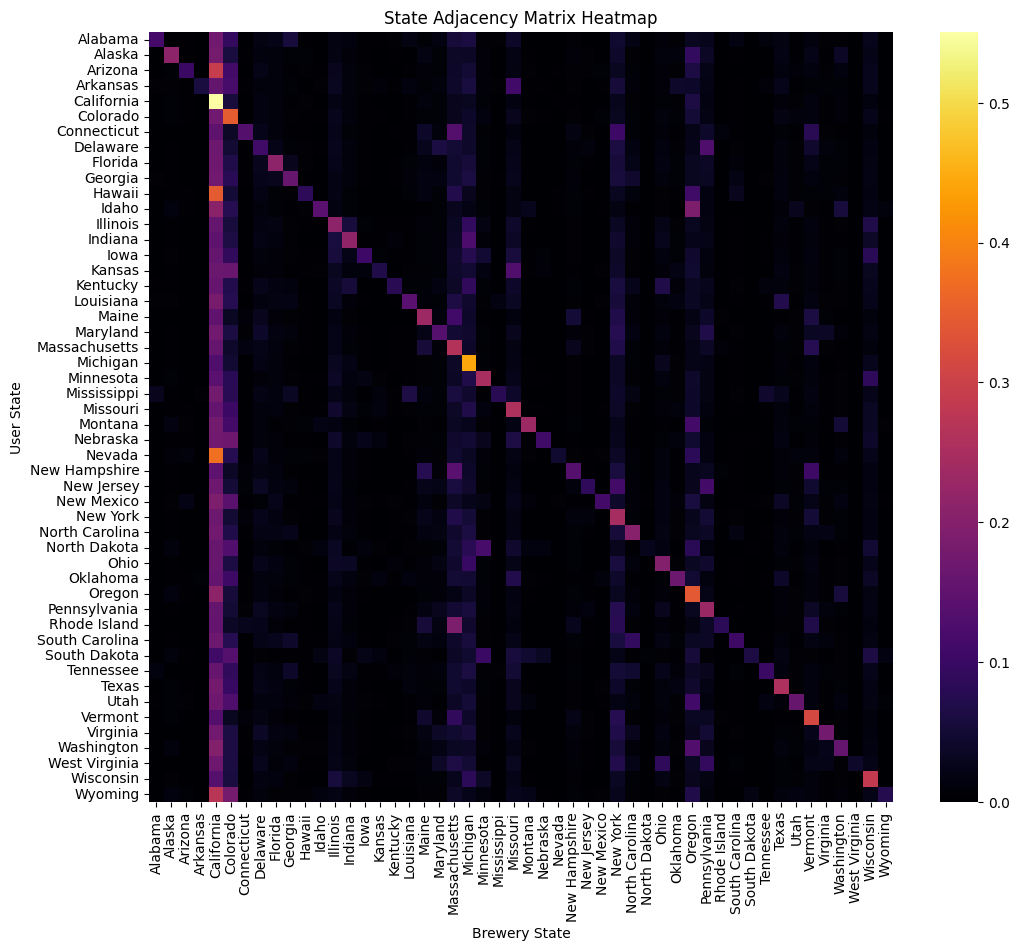

In [25]:
import seaborn as sns
def plot_heatmap(adj_matrix, title, xlabel, ylabel, ax=None):
    if ax:
        sns.heatmap(adj_matrix, cmap='inferno', ax=ax, cbar=False)
        ax.set_title(f"{title}")
    else:
        plt.figure(figsize=(12, 10))
        sns.heatmap(adj_matrix, cmap='inferno') 
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.show()

plot_heatmap(state_adj_matrix, title='State Adjacency Matrix Heatmap', xlabel='Brewery State', ylabel='User State')

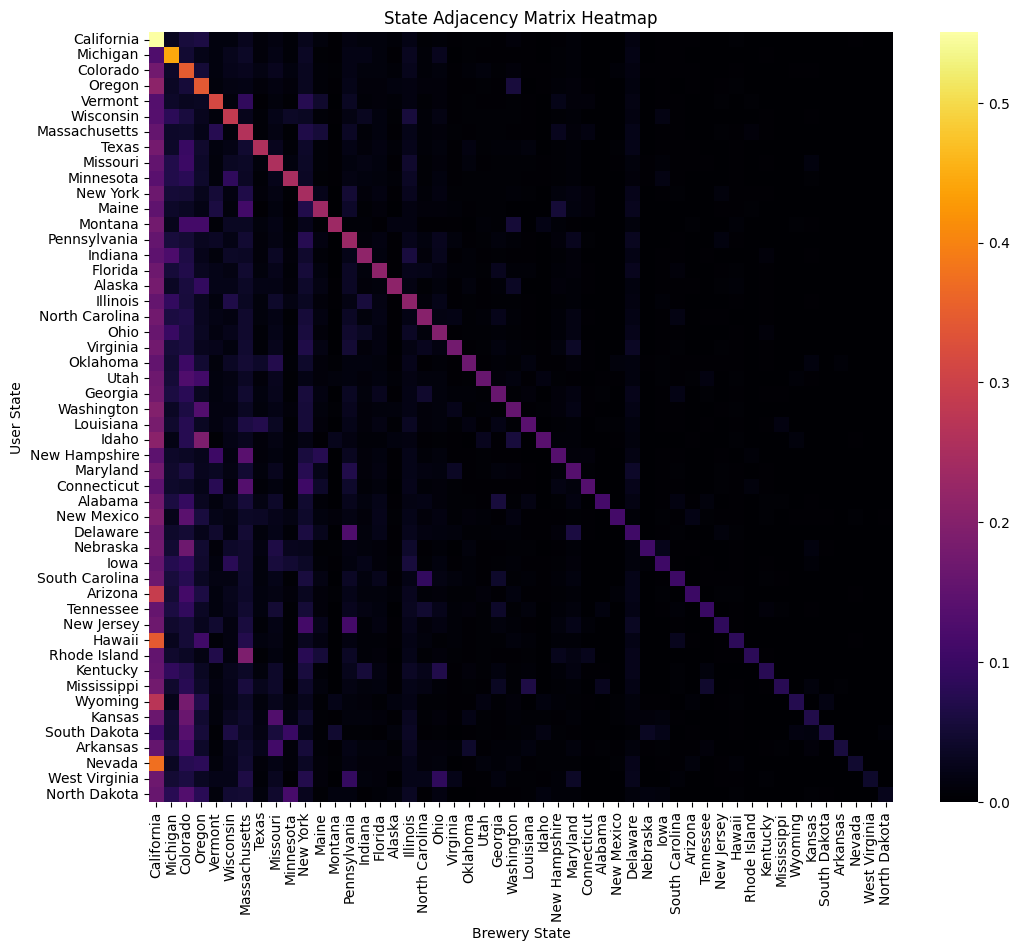

In [ ]:
plot_heatmap(sorted_ajd_matrix, title='State Adjacency Matrix Heatmap', xlabel='Brewery State', ylabel='User State')

In [27]:
from matplotlib.animation import FuncAnimation


def get_yearly_reviews(ba_usa_ratings_merged):
    reviews_by_year = ba_usa_ratings_merged.groupby(pd.to_datetime(ba_usa_ratings_merged["date"]).dt.year)
    return reviews_by_year

def create_gif(ba_usa_ratings_merged, states, save_file):
    yearly_reviews = {group: group_df for group, group_df in get_yearly_reviews(ba_usa_ratings_merged)}
    frame2year = {i: group for i, group in enumerate(yearly_reviews.keys())}
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.tight_layout()

    def update(frame):
        year = frame2year[frame]
        data = yearly_reviews[year]
        ax.clear()
        matrix = get_state_adjacency_matrix(data, states, as_ratio=True) 
        plot_heatmap(matrix, title=f'State Adjacency Matrix {year}', xlabel='Brewery State', ylabel='User State', ax=ax)
        fig.tight_layout()
        plt.close(fig)

    anim = FuncAnimation(fig, update, frames=len(frame2year), repeat=True)  
    anim.save(save_file, writer="pillow", fps=2) 

create_gif(ba_usa_ratings_merged, states, "animation.gif")

## Year by year local consumption

In [28]:
#convert cursed date format to normal date
ba_usa_ratings['date'] = pd.to_datetime(ba_usa_ratings['date'])

#separate in months
ba_usa_ratings['year_month'] = ba_usa_ratings['date'].dt.to_period('M')

dic_state_provenance = {key: {} for key in user_state_dic.keys()}


for key in user_state_dic.keys():
    user_state_dic[key]['year_month'] = pd.to_datetime(user_state_dic[key]['date']).dt.to_period('M')


#gather monthly data
for key in user_state_dic.keys():
    
    monthly_data = user_state_dic[key].groupby('year_month')
    dic_state_provenance[key]['local_count'] = monthly_data.apply(lambda x: x[x['user_state'] == x['brewery_state']].shape[0], include_groups=False)
    dic_state_provenance[key]['national_count'] = monthly_data.apply(lambda x: x[x['brewery_state'].isin(user_state_dic.keys() - {key})].shape[0], include_groups=False)
    dic_state_provenance[key]['foreign_count'] = monthly_data.apply(lambda x: x[~x['brewery_state'].isin(user_state_dic.keys())].shape[0], include_groups=False) 
    

In [29]:
cnt = 0
for a in dic_state_provenance['Washington']['local_count'].keys():
    print(a)
    cnt += 1
    if cnt == 20:
        break

2002-10
2002-11
2003-01
2003-02
2003-03
2003-04
2003-05
2003-06
2003-07
2003-08
2003-09
2003-10
2003-11
2003-12
2004-01
2004-02
2004-03
2004-04
2004-05
2004-06


In [30]:
dic_state_provenance['all_states'] = {}

for date_key in dic_state_provenance['Washington']['local_count'].keys():
    date_key_str = str(date_key)
    if date_key_str not in dic_state_provenance['all_states']:
        dic_state_provenance['all_states'][date_key_str] = {
            'local_count': 0,
            'national_count': 0,
            'foreign_count': 0
        }

    #conbine cnts for all states
    for state_key in dic_state_provenance.keys():
        if state_key == 'all_states':
            continue

        dic_state_provenance['all_states'][date_key_str]['local_count'] += dic_state_provenance[state_key]['local_count'].get(date_key, 0)
        dic_state_provenance['all_states'][date_key_str]['national_count'] += dic_state_provenance[state_key].get('national_count', {}).get(date_key, 0)
        dic_state_provenance['all_states'][date_key_str]['foreign_count'] += dic_state_provenance[state_key].get('foreign_count', {}).get(date_key, 0)


In [31]:
dic_state_provenance['all_states']

{'2002-10': {'local_count': np.int64(321),
  'national_count': np.int64(1070),
  'foreign_count': np.int64(883)},
 '2002-11': {'local_count': np.int64(336),
  'national_count': np.int64(1372),
  'foreign_count': np.int64(847)},
 '2003-01': {'local_count': np.int64(473),
  'national_count': np.int64(1537),
  'foreign_count': np.int64(1259)},
 '2003-02': {'local_count': np.int64(375),
  'national_count': np.int64(1628),
  'foreign_count': np.int64(1094)},
 '2003-03': {'local_count': np.int64(424),
  'national_count': np.int64(1829),
  'foreign_count': np.int64(1227)},
 '2003-04': {'local_count': np.int64(405),
  'national_count': np.int64(1652),
  'foreign_count': np.int64(1086)},
 '2003-05': {'local_count': np.int64(373),
  'national_count': np.int64(1837),
  'foreign_count': np.int64(1128)},
 '2003-06': {'local_count': np.int64(412),
  'national_count': np.int64(1876),
  'foreign_count': np.int64(1190)},
 '2003-07': {'local_count': np.int64(509),
  'national_count': np.int64(1926),
  '

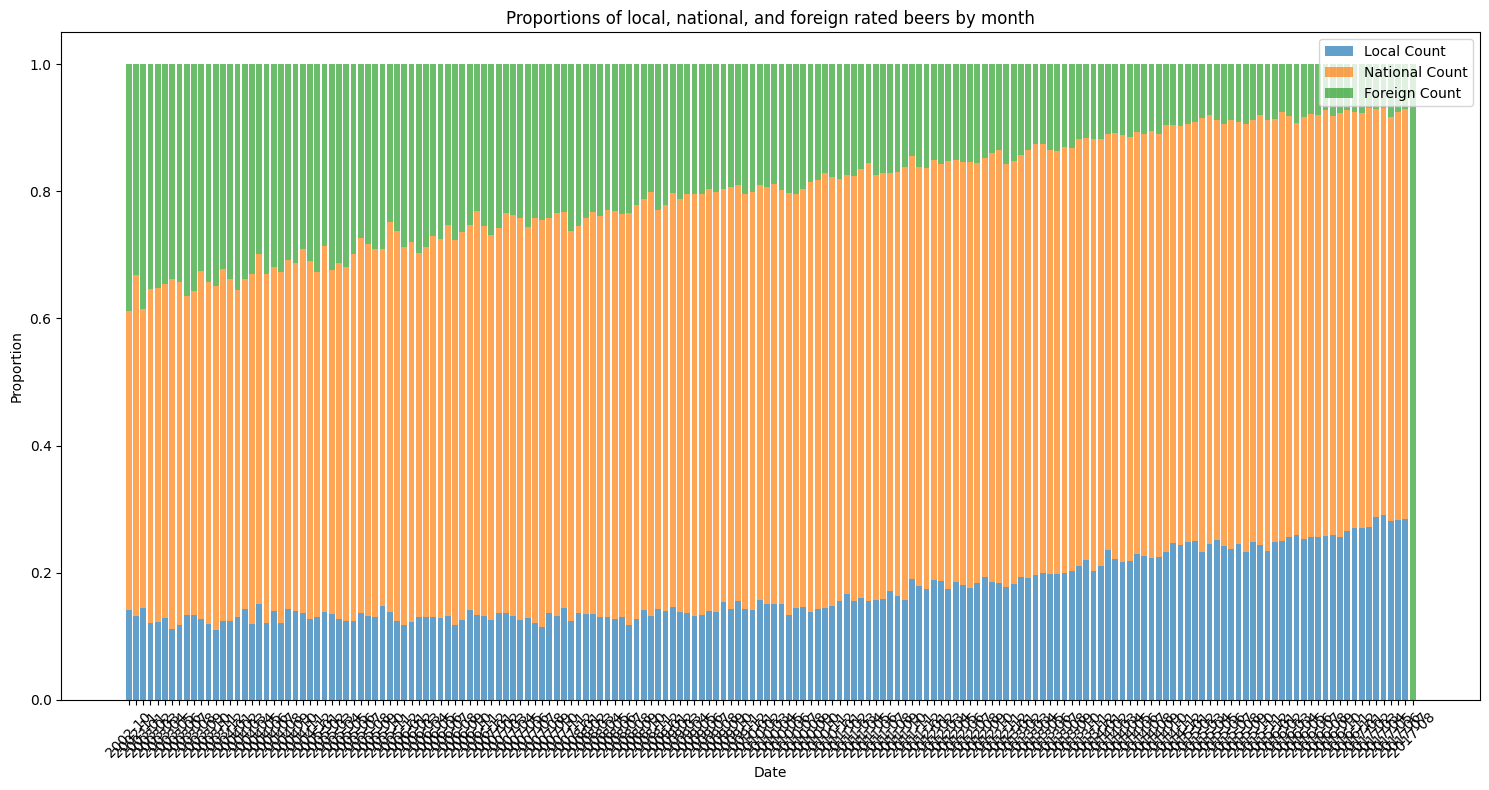

In [32]:
dates = []
local_proportions = []
national_proportions = []
foreign_proportions = []

for date, data in dic_state_provenance['all_states'].items():
    total = data['local_count'] + data['national_count'] + data['foreign_count']
    if total > 0:
        dates.append(date)
        local_proportions.append(data['local_count'] / total)
        national_proportions.append(data['national_count'] / total)
        foreign_proportions.append(data['foreign_count'] / total)

dates, local_proportions, national_proportions, foreign_proportions = zip(
    *sorted(zip(dates, local_proportions, national_proportions, foreign_proportions))
)

plt.figure(figsize=(15, 8))
plt.bar(dates, local_proportions, label='Local Count', alpha=0.7)
plt.bar(dates, national_proportions, bottom=local_proportions, label='National Count', alpha=0.7)
plt.bar(
    dates, foreign_proportions,
    bottom=[i + j for i, j in zip(local_proportions, national_proportions)],
    label='Foreign Count', alpha=0.7
)

plt.xlabel('Date')
plt.ylabel('Proportion')
plt.title('Proportions of local, national, and foreign rated beers by month')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
def get_reviews_by_month(ratings_breweries_merged, start_month=None, end_month=None):
    if start_month:
        ratings_breweries_merged = ratings_breweries_merged[pd.to_datetime(ratings_breweries_merged["date"]).dt.date >= start_month]
    if end_month:
        ratings_breweries_merged = ratings_breweries_merged[pd.to_datetime(ratings_breweries_merged["date"]).dt.date <= end_month]
    reviews_by_month = ratings_breweries_merged.groupby(pd.to_datetime(ratings_breweries_merged["date"]).dt.to_period('M'))
    return reviews_by_month

def get_state_counts_by_month(reviews_by_month, cumulative=False):
    """
    Get a table indexed by year-month and user_state with the column for different brewery location, the values are the number of reviews from user_state to brewery_state.
    If cumulative, it's the total number of reviews from user_state to brewery_state at that point in time.
    """
    # For each month get the matrix of review count from user state to brewery locations
    counts_by_month = reviews_by_month.apply(lambda x: get_state_adjacency_matrix(x, states, as_ratio=False, drop_world=False).fillna(0))
    if cumulative:
        counts_by_month = counts_by_month.groupby(level="user_state").cumsum()
    return counts_by_month




start_month = datetime.strptime("2002-10", "%Y-%m").date()
end_month = datetime.strptime("2017-07", "%Y-%m").date()



2002-10-01


brewery_state          Alabama  Alaska  Arizona  Arkansas  California  \
date    user_state                                                      
2002-10 Alabama              0       0        0         0           0   
        Alaska               0       0        0         0           0   
        Arizona              0       0        7         0          14   
        Arkansas             0       0        0         0           0   
        California           0       0        4         0          59   
...                        ...     ...      ...       ...         ...   
2017-07 Virginia             0       0        0         0          12   
        Washington           0       0        0         0           9   
        West Virginia        0       0        0         0           0   
        Wisconsin            0       0        0         0          11   
        Wyoming              0       0        0         0           0   

brewery_state          Colorado  Connecticut  Delaware  Florida  Georgia  ...  \
date    user_state                                                        ...   
2002-10 Alabama               0            0         0        0        0  ...   
        Alaska                0            0         0        0        0  ...   
        Arizona               6            5         0        1        6  ...   
        Arkansas              0            0         0        0        0  ...   
        California            6            0         1        1        0  ...   
...                         ...          ...       ...      ...      ...  ...   
2017-07 Virginia              2            3         0        0        1  ...   
        Washington            2            0         0        1        0  ...   
        West Virginia         0            0         0        0        0  ...   
        Wisconsin             0            1         0        0        2  ...   
        Wyoming               0            0         0        1        0  ...   

brewery_state          Tennessee  Texas  Utah  Vermont  Virginia  Washington  \
date    user_state                                                             
2002-10 Alabama                0      0     0        0         0           0   
        Alaska                 0      0     0        0         0           0   
        Arizona                0      0     0        4         4           5   
        Arkansas               0      0     0        0         0           0   
        California             0      3     0        1         0           5   
...                          ...    ...   ...      ...       ...         ...   
2017-07 Virginia               0      1     1        0        18           0   
        Washington             1      1     0        0         4          18   
        West Virginia          0      0     0        0         0           0   
        Wisconsin              0      0     0        0         0           0   
        Wyoming                0      0     0        0         0           0   

brewery_state          West Virginia  Wisconsin  Wyoming  World  
date    user_state                                               
2002-10 Alabama                    0          0        0    0.0  
        Alaska                     0          0        0    0.0  
        Arizona                    0          3        0   57.0  
        Arkansas                   0          0        0    0.0  
        California                 0          1        0  131.0  
...                              ...        ...      ...    ...  
2017-07 Virginia                   0          0        0    4.0  
        Washington                 0          0        0    0.0  
        West Virginia              0          0        0    0.0  
        Wisconsin                  0         12        0    2.0  
        Wyoming                    0          0        1    0.0  

[8900 rows x 51 columns]

In [ ]:
def get_counts_for_date(sub_df):
    local_count = np.diagonal(sub_df.drop(columns=["user_state", "date", "World"])).sum()
    foreign_count = sub_df['World'].sum() if 'World' in sub_df.columns else 0
    non_world_sum = np.array(sub_df.drop(columns=["user_state", 'World', 'date'])).sum()
    national_count = non_world_sum - local_count

    return pd.Series({
        'local_count': local_count,
        'national_count': national_count,
        'foreign_count': foreign_count
    })

def get_total_counts_from_monthly(counts_by_month, as_ratio=True):
    """
    Takes in a dataframe with the count of reviews from user state to brewery state by month and outputs a df with the local_count, national_count and foreign_count by month
    """
    counts_by_month_compact = counts_by_month.reset_index().groupby("date").apply(get_counts_for_date)
    if as_ratio:
        row_sums = counts_by_month_compact.sum(axis=1)
        ratios_by_month_collapsed = counts_by_month_compact.div(row_sums, axis=0).fillna(0)
        return ratios_by_month_collapsed
    return counts_by_month_compact

def get_us_counts(ratings_brewery_merged, start_month=None, end_month=None, cumulative=False, as_ratio=True):
    """
    From a merged ratings and breweries dataframe (you need a user_state and a brewery_state column) outputs the local_count, national_count and foreign_count by month
    """
    rev_monthly = get_reviews_by_month(ratings_brewery_merged, start_month=start_month, end_month=end_month)
    counts_by_month = get_state_counts_by_month(rev_monthly, cumulative=cumulative)
    us_counts = get_total_counts_from_monthly(counts_by_month, as_ratio=as_ratio)
    return us_counts


start_month = datetime.strptime("2002-10", "%Y-%m").date()
end_month = datetime.strptime("2017-07", "%Y-%m").date()
us_counts = get_us_counts(ba_usa_ratings_merged, start_month=start_month, end_month=end_month, cumulative=False, as_ratio=True)

/var/folders/_b/w9s75zbd5tsf70gz6vs4nshh0000gn/T/ipykernel_7719/528063260.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  counts_by_month_compact = counts_by_month.reset_index().groupby("date").apply(get_counts_for_date)


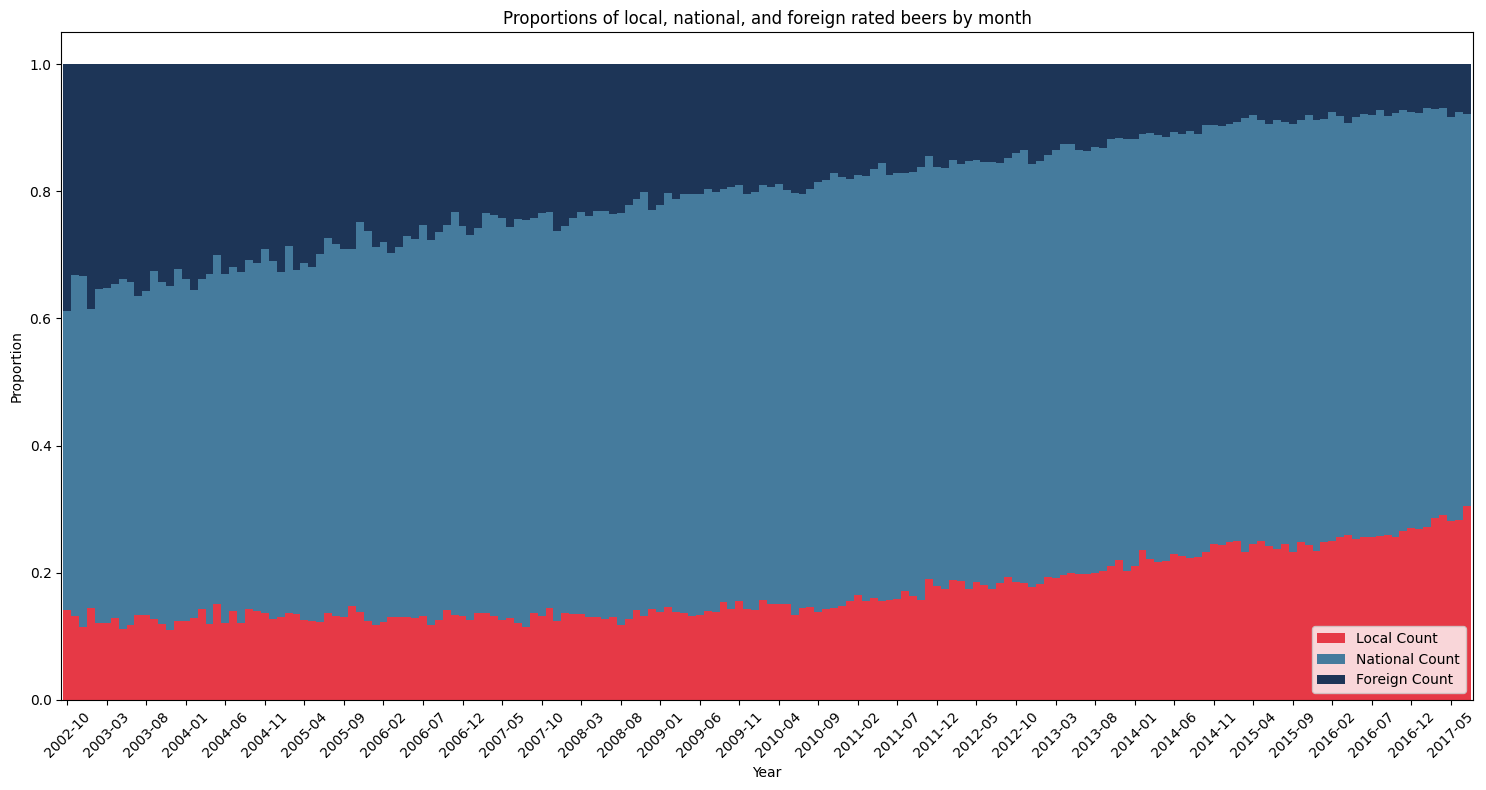

In [206]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
colors = {
            "local_count": "#e63946",
            "national_count": "#457b9d",
            "foreign_count": "#1d3557"
        }

legends = [column.replace("_", " ").title() for column in list(us_counts.columns)]
ax = us_counts.plot(kind='bar', stacked=True, figsize=(15,8), width=1.0, color=colors)
ax.legend(legends,
            loc='lower right' , fontsize='medium')


ticks = ax.get_xticks()
labels = [tick.get_text() for tick in ax.get_xticklabels()]

step = 5
ax.set_xticks(ticks[::step])
ax.set_xticklabels(labels[::step], rotation=45)

plt.xticks(rotation=45)
plt.title('Proportions of local, national, and foreign rated beers by month')
plt.ylabel('Proportion')
plt.xlabel('Year')
plt.tight_layout()
plt.show()


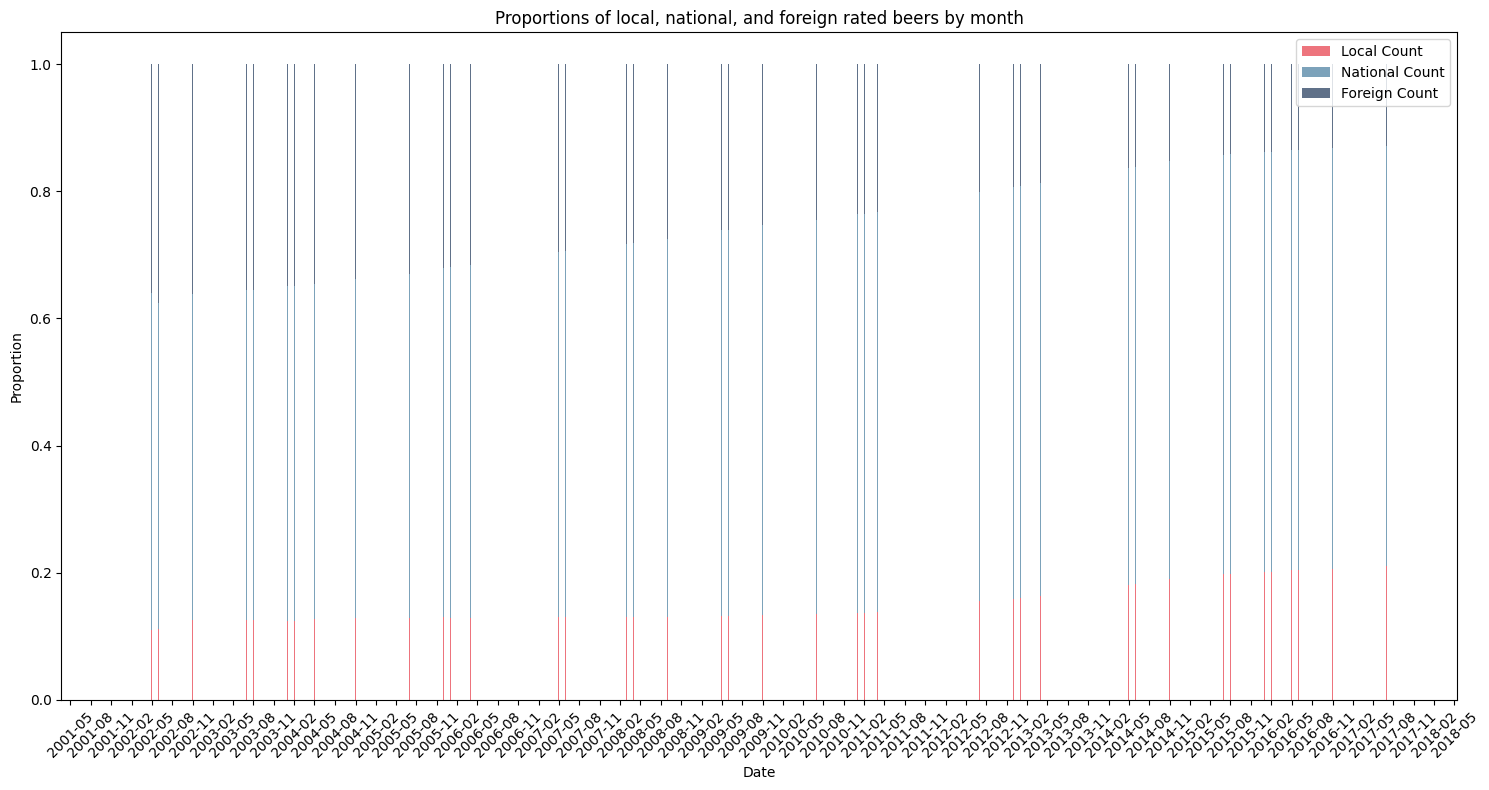

In [171]:
counts_by_month.groupby(level="user_state").cumsum().loc["2002-02"]

brewery_state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,World
user_state,,,,,,,,,,,,,,,,,,,,,
Alabama,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Alaska,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Arizona,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,9.0
Arkansas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
California,0,0,0,0,31,7,1,0,0,0,...,0,1,0,12,0,3,0,0,0,31.0
Colorado,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Connecticut,0,0,0,0,1,0,6,0,0,0,...,0,0,0,5,0,0,0,0,0,15.0
Delaware,0,0,0,0,4,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,6.0
Florida,0,0,0,0,6,0,0,0,1,0,...,0,0,0,0,0,2,0,2,0,9.0
